In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import torch
from torchvision import models
import torch.nn as nn

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained EfficientNet-B0 Architecture (Without Pretrained Weights)
model = models.efficientnet_b0(pretrained=False)

# Get Input Features for Classifier
num_ftrs = model.classifier[1].in_features

# Define the Classifier Exactly as Used in Training
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.4),  # Dropout for regularization
    nn.Linear(num_ftrs, 16)  # Match the trained model (16 classes)
)

# Load Model Weights
model_path = "/content/drive/MyDrive/Colab Notebooks/Images/best_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

# Move to Device & Set to Evaluation Mode
model.to(device)
model.eval()

print("Model Loaded Successfully with Correct Architecture!")


Model Loaded Successfully with Correct Architecture!


In [8]:
import pandas as pd

# Load the dataset CSV (Update path if needed)
csv_path = "/content/drive/MyDrive/dataset_labels.csv"
df = pd.read_csv(csv_path)

# Extract unique class labels in the order they were encoded
sorted_classes = sorted(df["label"].unique())
print("\nClasses used in training (Correct Order):")
for idx, cls in enumerate(sorted_classes):
    print(f"{idx}: {cls}")



Classes used in training (Correct Order):
0: Boundary wall
1: Chimney
2: Concrete Column
3: Concrete footing
4: Construction worker
5: Earth mover
6: Electric generator
7: Excavated Pit
8: Land
9: Power lines
10: Residential
11: Solar panel
12: Staircase
13: Tower crane
14: Tree
15: Water tank


In [9]:
# Set class_names based on the actual dataset order
class_names = sorted_classes  # Ensures correct mapping


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Define Image Preprocessing (Must Match Training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

# Class Labels (Update If Needed)
class_names = ["Boundary Wall", "Chimney", "Concrete Column", "Concrete Footing",
               "Construction Worker", "Earth Mover", "Electric Generator",
               "Excavated Pit", "Land", "Power Lines", "Residential",
               "Solar Panel", "Staircase", "Tower Crane", "Tree", "Water Tank"]

def preprocess_image(image_path):
    """Loads an image, verifies format, and preprocesses it for EfficientNet."""
    try:
        # Open image and convert to RGB
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        image = transform(image)

        # Add batch dimension (1, C, H, W)
        image = image.unsqueeze(0)

        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None  # Handle error gracefully

def visualize_predictions(image_paths):
    """Processes & visualizes 16 test images with predictions & confidence scores."""
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    #fig, axes = plt.subplots(4, 4, figsize=(16, 16))  # 4x4 grid for 16 images
    axes = axes.flatten()  # Flatten axes for easy iteration

    for idx, image_path in enumerate(image_paths[:16]):  # Limit to 16 images
        image = preprocess_image(image_path)
        if image is None:
            continue

        # Move image to GPU if available
        image = image.to(device)

        # Run Inference
        with torch.no_grad():
            output = model(image)
            probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Convert logits to probabilities
            predicted_class = torch.argmax(probabilities).item()
            confidence = probabilities[predicted_class].item()

        # Load image for display
        img = Image.open(image_path).convert("RGB")

        # Display image
        axes[idx].imshow(img)
        axes[idx].axis("off")
        axes[idx].set_title(f"Pred: {class_names[predicted_class]}\nConf: {confidence*100:.2f}%", fontsize=12)

    plt.tight_layout()
    plt.show()


In [10]:
import torch.nn.functional as F

# Pick a test image (Update path if needed)
test_image = preprocess_image("/content/drive/MyDrive/test images/boundary wall.jpeg")
test_image = test_image.to(device)

# Get model prediction
with torch.no_grad():
    output = model(test_image)
    probabilities = F.softmax(output[0], dim=0)
    top5_prob, top5_idx = torch.topk(probabilities, 5)  # Get top 5 predictions

print("\nTop 5 Predictions with Confidence Scores:")
for i in range(5):
    print(f"{class_names[top5_idx[i].item()]}: {top5_prob[i].item()*100:.2f}%")



Top 5 Predictions with Confidence Scores:
Boundary wall: 99.04%
Chimney: 0.31%
Residential: 0.17%
Solar panel: 0.11%
Staircase: 0.10%



Image: boundary wall.jpeg
Predicted: Boundary Wall (99.04%)

Image: concrete pillar.jpeg
Predicted: Concrete Column (97.88%)

Image: construction worker.jpeg
Predicted: Residential (98.93%)

Image: concrete footing.jpeg
Predicted: Concrete Footing (99.07%)

Image: tree.jpeg
Predicted: Residential (13.71%)


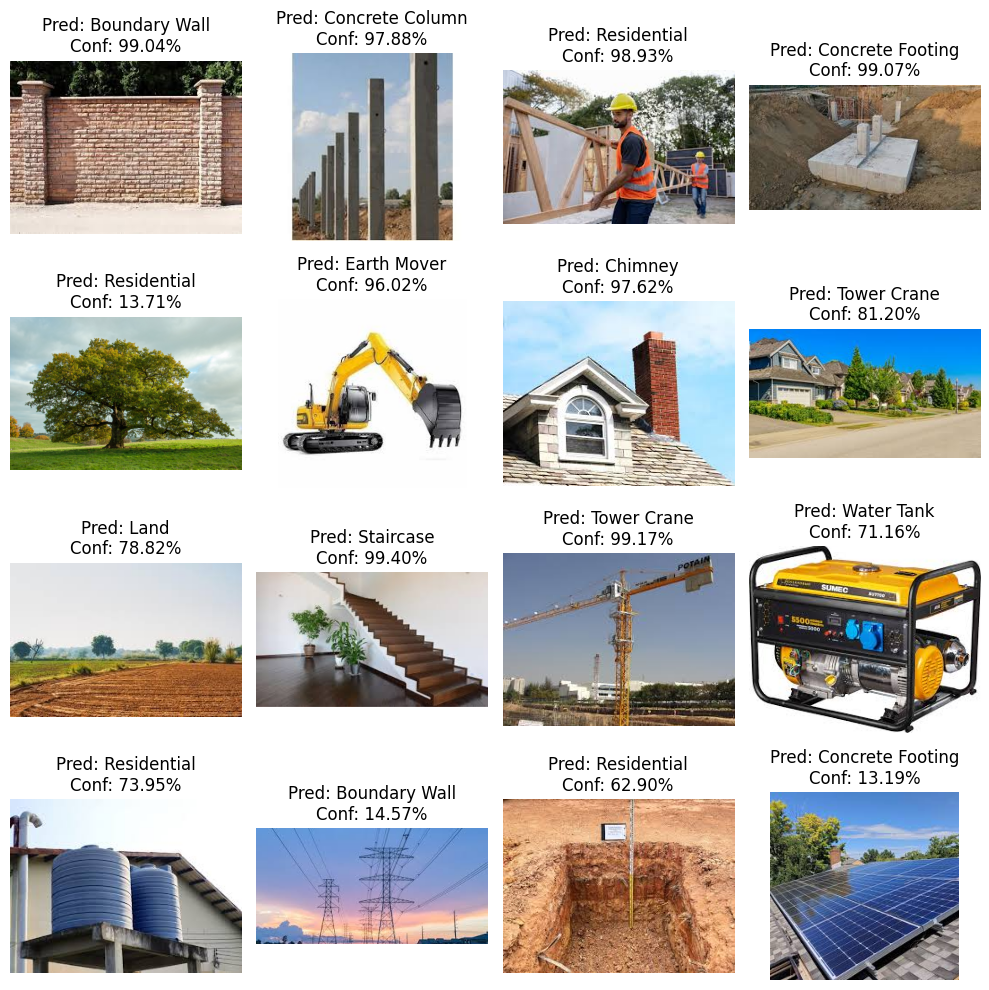

In [18]:
test_folder = "/content/drive/MyDrive/test images"

# Get test images
test_images = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]

for image_path in test_images[:5]:  # Test on 5 images
    image = preprocess_image(image_path).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item()

    print(f"\nImage: {os.path.basename(image_path)}")
    print(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}%)")
visualize_predictions(test_images)
